# <b> <center> <font color='#7B241C'> FRUIT CLASSIFICATION AND LOCALIZATION </font> </center> </b>

## <font color='blue'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Pre-processing](#4)
5. [Build, train and compile a model](#5)
6. [Making predictions](#6)
7. [References](#references)

<a name="1"></a>
## <b> <font color='red'> 1. Introduction </font> </b>

In this notebook, we tackle an object classification and localization problem using a dataset of fruit images.

Each image may contain multiple fruits, but only one fruit per image is annotated with a bounding box and class label (apple, banana, or orange). Our objectives are to:

- Classify the annotated fruit

- Predict its bounding box within the image

We will walk through the full pipeline:

- Data preprocessing – resize images, normalize pixel values, scale bounding box coordinates, and one-hot encode class labels.

- Model building – define a neural network that predicts both the class and the bounding box.

- Training – train the model on labeled data.

- Evaluation and prediction – assess performance and make predictions on new images.

This end-to-end workflow demonstrates how to handle combined classification and localization tasks in computer vision.

<a name="2"></a>
## <b> <font color='red'> 2. Setup </font>  </b>

In [88]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.layers import Conv2D, Reshape

import os
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [4]:
tf.random.set_seed(42)

<a name="3"></a>
## <b> <font color='red'> 3. Helper Functions </font>  </b>

In [6]:
# plotting utilities
def plot_image_and_label(image, coord):
    """
    image: image
    coord: bounding box coordinates
    """
    # Create a figure and axes object
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(image)
    # Define the coordinates and dimensions of the bounding box
    x, y, w, h = coord
    # Create a rectangle representing the bounding box
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
    # Add the rectangle to the axes
    ax.add_patch(rect)
    # Show the image with the bounding box
    plt.show()


In [43]:
# Pre-processing

# Función para leer las anotaciones XML y extraer las coordenadas de las cajas delimitadoras
def parse_annotation(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    # Extraer la etiqueta 'object' que contiene la información de la caja delimitadora
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        # Retornar las coordenadas de la caja delimitadora y la etiqueta
        return xmin, ymin, xmax, ymax, name


# Example of image and label preprocessing
def preprocess_image(image_path):
    # Load the image and resize it
    image = cv2.imread(image_path)
    # Convert the image to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # cv2 uses BGR by default
    # Resize the image
    image = cv2.resize(image, (224, 224))  # resize keeps the color channels!
    # Normalize pixel values to the range [0, 1]
    image = image / 255.0  
    return image


# Scaling coordinates of the bounding box
def scaling_coordinates(coord, width, height, resized_width, resized_height):
    x, y, w, h = coord
    scale_x = resized_width / width
    scale_y = resized_height / height
    x_scaled = int(x * scale_x)
    y_scaled = int(y * scale_y)
    w_scaled = int(w * scale_x)
    h_scaled = int(h * scale_y)
    return [x_scaled, y_scaled, w_scaled, h_scaled]


# load images and annotations
def load_images_and_labels(images_dir, annotations_dir, parse_annotation_fn):
    """
    Load image file paths and corresponding labels from an annotation directory.

    Args:
        images_dir (str): Path to the directory containing image files.
        annotations_dir (str): Path to the directory containing annotation files (.xml).
        parse_annotation_fn (function): Function to parse a single annotation file.
                                        Must return (xmin, ymin, xmax, ymax, label).

    Returns:
        tuple: A tuple (image_paths, labels), where:
            - image_paths (list of str): Paths to image files.
            - labels (list of list): Each item is [xmin, ymin, xmax, ymax, label].
    """
    image_paths = []
    labels = []

    for annotation_file in os.listdir(annotations_dir):
        if annotation_file.endswith('.xml'):
            annotation_path = os.path.join(annotations_dir, annotation_file)
            image_name = annotation_file.replace('.xml', '.jpg')
            image_path = os.path.join(images_dir, image_name)

            xmin, ymin, xmax, ymax, label = parse_annotation_fn(annotation_path)

            image_paths.append(image_path)
            labels.append([xmin, ymin, xmax, ymax, label])

    return image_paths, labels


# format labels
def format_labels(raw_labels):
    """
    Convert raw labels into a list of dictionaries with 'bbox' and 'class' keys.

    Args:
        raw_labels (list of lists): Each element is a list like [xmin, ymin, xmax, ymax, label].

    Returns:
        list of dicts: Each dict has keys:
            - 'bbox': list of bounding box coordinates [xmin, ymin, xmax, ymax]
            - 'class': class label
    """
    formatted = []
    for label in raw_labels:
        formatted.append({'bbox': label[0:4], 'class': label[4]})
    return formatted

# encode labels
def encode_labels(labels, one_hot_encoding):
    """
    Encode class labels as one-hot vectors while preserving bounding boxes.

    Args:
        labels (list of dict): Each dict contains 'class' (str) and 'bbox' (list of coordinates).
        one_hot_encoding (dict): Mapping from class names to one-hot vectors.

    Returns:
        list of dict: Each dict has:
            - 'class': one-hot encoded class vector (list)
            - 'bbox': bounding box coordinates (list)
    """
    encoded = []
    for label in labels:
        class_name = label['class']
        encoded.append({
            'class': one_hot_encoding[class_name],
            'bbox': label['bbox']
        })
    return encoded


# scale bounding boxes
def scale_bounding_boxes(images, labels, target_width, target_height, scale_func):
    """
    Scale bounding box coordinates to match resized images.

    Args:
        images (list of str): Paths to images.
        labels (list of dict): Each dict has 'bbox' and 'class'.
        target_width (int): Width of the resized images.
        target_height (int): Height of the resized images.
        scale_func (function): Function to scale bbox coords: 
            scale_func(bbox, orig_w, orig_h, target_w, target_h) -> scaled_bbox

    Returns:
        list of dict: Updated labels with scaled bounding boxes.
    """
    scaled_labels = []
    for img_path, label in zip(images, labels):
        image = cv2.imread(img_path)
        orig_h, orig_w = image.shape[:2]
        scaled_bbox = scale_func(label['bbox'], orig_w, orig_h, target_width, target_height)
        scaled_labels.append({
            'bbox': scaled_bbox,
            'class': label['class']
        })
    return scaled_labels


# Create TF Dataset
def create_dataset(images, one_hot_labels, batch_size=batch_size, training=True):
    """
    Creates a TensorFlow dataset from image paths and one-hot encoded labels.

    Parameters:
    - images: list of file paths to the input images.
    - one_hot_labels: list of dictionaries with keys 'bbox' and 'class'. 
                      'bbox' contains bounding box coordinates [x_min, y_min, x_max, y_max], 
                      and 'class' is a one-hot encoded class label.
    - batch_size: number of samples per batch.

    Returns:
    - A tf.data.Dataset object with (image, label) pairs, where label is a dictionary 
      containing 'bbox' and 'class'. The dataset is batched and shuffled.
    """
    # Preprocess the images
    images = [preprocess_image(path) for path in images]
    # Convert bounding box coordinates to tensors
    bounding_boxes = tf.constant([obj['bbox'] for obj in one_hot_labels], dtype=tf.float32)
    # Convert one-hot class labels to tensors
    classes = tf.constant([obj['class'] for obj in one_hot_labels], dtype=tf.float32)
    # Create a dictionary of label tensors
    dataset_labels = {'bbox': bounding_boxes, 'class': classes}
    # Create the dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, dataset_labels))
    # Shuffle and batch
    dataset = dataset.batch(batch_size)

    if training:
        dataset.shuffle(buffer_size=len(images))
    
    return dataset


<a name="4"></a>
## <b> <font color='red'> 4. Pre-processing </font>  </b>

In [30]:
# image and annotation folders
train_images_dir = 'data/train'
train_annotations_dir = 'data/train'
test_images_dir = 'data/test'
test_annotations_dir = 'data/test'

In [32]:
train_images, train_labels = load_images_and_labels(train_images_dir, train_annotations_dir, parse_annotation)
test_images, test_labels = load_images_and_labels(test_images_dir, test_annotations_dir, parse_annotation)

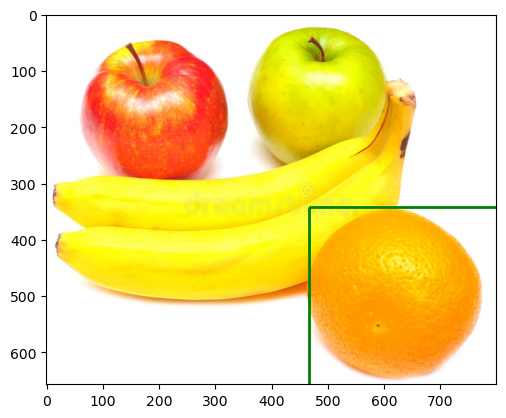

In [33]:
plot_image_and_label(Image.open(train_images[7]), train_labels[7][0:4])

In [35]:
train_labels = format_labels(train_labels)
test_labels = format_labels(test_labels)

# see a couple of labels
test_labels[2:4]

[{'bbox': [313, 228, 935, 1864], 'class': 'banana'},
 {'bbox': [77, 183, 641, 716], 'class': 'apple'}]

In [38]:
# get unique classes
unique_classes = sorted(set(label['class'] for label in train_labels)) # ['banana', 'apple', 'orange']

# num classes
num_classes = len(unique_classes)

# encoding
one_hot_encoding = {class_name: [0] * len(unique_classes) for class_name in unique_classes}
for i, class_name in enumerate(unique_classes):
    one_hot_encoding[class_name][i] = 1

In [39]:
unique_classes, num_classes

(['apple', 'banana', 'orange'], 3)

In [40]:
one_hot_encoding

{'apple': [1, 0, 0], 'banana': [0, 1, 0], 'orange': [0, 0, 1]}

In [68]:
class_labels = {0:'apple', 1: 'banana', 2: 'orange'}

In [42]:
# encode each label
train_encoded_labels = encode_labels(train_labels, one_hot_encoding)
test_encoded_labels = encode_labels(test_labels, one_hot_encoding)


# print a one_hot encoded label
first_label = train_encoded_labels[0]
print("Class (one-hot encoded):", first_label['class'])
print("Bounding Box:", first_label['bbox'])

Class (one-hot encoded): [1, 0, 0]
Bounding Box: [304, 105, 773, 439]


In [47]:
train_scaled_labels = scale_bounding_boxes(train_images, train_encoded_labels, 224, 224, scaling_coordinates)
test_scaled_labels = scale_bounding_boxes(test_images, test_encoded_labels, 224, 224, scaling_coordinates)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [48]:
train_scaled_labels[7:9]

[{'bbox': [130, 116, 217, 224], 'class': [0, 0, 1]},
 {'bbox': [106, 26, 221, 186], 'class': [1, 0, 0]}]

**TF Datasets**

In [49]:
batch_size = 32

train_dataset = create_dataset(train_images, train_scaled_labels, batch_size)
val_dataset = create_dataset(test_images, test_scaled_labels, batch_size, training=False)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
2025-05-22 19:10:09.840010: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 289013760 exceeds 10% of free system memory.
libpng warning: iCCP: known incorrect sRGB profile


In [54]:
for x, y in train_dataset.take(1):
    print("First image:", x[0])
    print("First bounding box:", y['bbox'][0].numpy())
    print("First class (one-hot):", y['class'][0].numpy())


First image: tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(224, 224, 3), dtype=float64)
First bounding box: [ 87.  53. 221. 224.]
First class (one-hot): [1. 0. 0.]


In [56]:
for x, y in val_dataset.take(1):
    print("First image:", x[0])
    print("First bounding box:", y['bbox'][0].numpy())
    print("First class (one-hot):", y['class'][0].numpy())

First image: tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(224, 224, 3), dtype=float64)
First bounding box: [  5. 105. 189. 197.]
First class (one-hot): [0. 1. 0.]


<a name="5"></a>
## <b> <font color='red'> 5. Build, compile and train model </font>  </b>

In [76]:
def build_model(num_classes):
    """
    Builds a simple convolutional neural network model with two outputs:
    one for class prediction (classification) and one for bounding box regression (localization).

    Parameters:
        num_classes (int): Number of object classes for classification.

    Returns:
        tf.keras.Model: Compiled Keras model.
    """

    # Input layer
    input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

    # Convolutional layers
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(pool2)

    # Flatten and Dense layers
    flatten = tf.keras.layers.Flatten()(conv3)
    dense1 = tf.keras.layers.Dense(64, activation='relu')(flatten)

    # Output layers
    output_class = tf.keras.layers.Dense(num_classes, activation='softmax', name='class')(dense1)
    output_bbox = tf.keras.layers.Dense(4, activation='linear', name='bbox')(dense1)  # 4 coordinates for the bounding box

    # Build the model
    model = tf.keras.Model(inputs=input_layer, outputs=[output_class, output_bbox])

    # Compile the model with separate losses and metrics
    model.compile(optimizer='adam',
                  loss={'class': 'categorical_crossentropy', 'bbox': 'mse'},
                  metrics={'class': 'accuracy', 'bbox': 'mae'})
    
    return model


# Instantiate and summarize the model
model = build_model(num_classes)
model.summary()


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 222, 222, 32)         896       ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                     

In [77]:
# Entrenar el modelo
model.fit(
        train_dataset,
        validation_data = val_dataset,
        epochs=10)

Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 8926.3564 - class_loss: 28.9848 - bbox_loss: 8897.3721 - class_accuracy: 0.3167 - bbox_mae: 73.5444 - val_loss: 2927.3843 - val_class_loss: 20.0790 - val_bbox_loss: 2907.3057 - val_class_accuracy: 0.3167 - val_bbox_mae: 43.3261
Epoch 2/10
8/8 [==============================] - 8s 1s/step - loss: 2947.5803 - class_loss: 15.6432 - bbox_loss: 2931.9370 - class_accuracy: 0.3083 - bbox_mae: 42.6508 - val_loss: 2538.5713 - val_class_loss: 7.4033 - val_bbox_loss: 2531.1680 - val_class_accuracy: 0.3167 - val_bbox_mae: 38.4105
Epoch 3/10
8/8 [==============================] - 8s 1s/step - loss: 1956.9331 - class_loss: 7.3862 - bbox_loss: 1949.5469 - class_accuracy: 0.3083 - bbox_mae: 34.6423 - val_loss: 1482.6047 - val_class_loss: 7.8050 - val_bbox_loss: 1474.7997 - val_class_accuracy: 0.3500 - val_bbox_mae: 31.5450
Epoch 4/10
8/8 [==============================] - 8s 1s/step - loss: 1509.7880 - class_loss: 11.6179 - bbox_los

In [78]:
model.evaluate(val_dataset)

2/2 [==============================] - 0s 208ms/step - loss: 1135.4059 - class_loss: 1.2120 - bbox_loss: 1134.1938 - class_accuracy: 0.7333 - bbox_mae: 26.0601


[1135.4058837890625,
 1.2120310068130493,
 1134.19384765625,
 0.7333333492279053,
 26.060094833374023]

**Summary**

- Total Loss:        1135.41
- Classification Loss:   1.21
- BBox Loss (MSE):   1134.19
- Class Accuracy:     73.3%
- BBox MAE:           26.06


**Interpretation**

✅ Classification is working reasonably well with ~73% accuracy and a low categorical cross-entropy loss (1.21).

⚠️ Bounding box regression is poor. A very high MSE (1134.19) and MAE (26.06 pixels) indicate the model is not predicting bounding boxes accurately.


That could happen because we only trained the model for 10 epochs. However, keep in mind that the main goal here is not to achieve high performance, but rather to demonstrate how to approach a problem involving both object classification and localization.

<a name="6"></a>
## <b> <font color='red'> 6. Making predictions </font>  </b>

Let's make predictions with new images.

In [79]:
test_image_path = 'data/test_images/banana1.png'

test_image = preprocess_image(test_image_path)

test_image.shape

(224, 224, 3)

In [80]:
model.predict(test_image)

ValueError: in user code:

    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 224, 3)


We see that it gives an error: the model expects input of shape `(None, 224, 224, 3)`, but it receives `(32, 224, 3)`.

To fix this, we need to add one dimension to the input image.

In [81]:
expand_image = np.expand_dims(test_image, axis=0)
expand_image.shape

(1, 224, 224, 3)

In [82]:
preds = model.predict(expand_image)
preds

1/1 [==============================] - 0s 72ms/step


[array([[0.02538705, 0.7604577 , 0.2141552 ]], dtype=float32),
 array([[ 43.863194,  54.573627, 178.44052 , 194.0943  ]], dtype=float32)]

`preds` contains, on one hand, the class probabilities (how likely the model thinks it is a banana, apple, or orange — in `preds[0]`), and on the other hand, the bounding box coordinates (in `preds[1]`).

In [83]:
predicted_class = np.argmax(preds[0])
print(class_labels[predicted_class]) 

banana


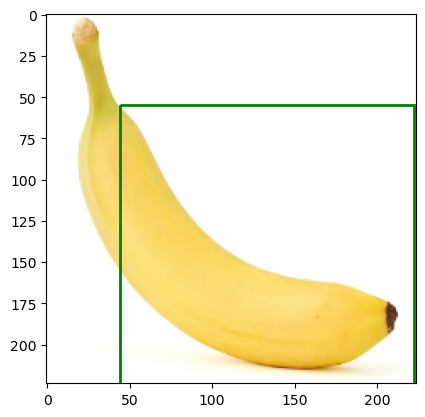

In [84]:
plot_image_and_label(test_image, preds[1][0])

In [85]:
preds[1]

array([[ 43.863194,  54.573627, 178.44052 , 194.0943  ]], dtype=float32)

Finally, let's create a function to make predictions:

In [86]:
def predict(image_path, model):
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)
    pred = model.predict(image)
    return pred

In [87]:
pred = predict('data/test_images/banana1.png', model)
pred

1/1 [==============================] - 0s 29ms/step


[array([[0.02538705, 0.7604577 , 0.2141552 ]], dtype=float32),
 array([[ 43.863194,  54.573627, 178.44052 , 194.0943  ]], dtype=float32)]

<a name="references"></a>
## <b> <font color='red'> References </font>  </b>

[TF Advanced Techniques Specialization](https://www.coursera.org/specializations/tensorflow-advanced-techniques)
